# Continuation of the last ntoebook to address some issue with training during the first

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
import torchvision.models.video as video_models
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import json

/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-07-18 12:52:27.142020: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 12:52:27.366395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-18 12:52:27.455442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for p

### Dataset

In [ ]:
import video_dataset as Dataset
transform = transforms.Compose([
    transforms.Lambda(lambda x: Dataset.correct_num_frames(x, 16)),  # (T, C, H, W)
    transforms.Lambda(lambda x: x.float() / 255.0),  # Convert to float and normalize to [0,1]
    transforms.Lambda(lambda x: F.interpolate(x, size=(112, 112), mode='bilinear', align_corners=False)),  # Resize after normalization
    transforms.Lambda(lambda x: Dataset.normalise(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])),  # Normalize per channel
    transforms.Lambda(lambda x: x.permute(1, 0, 2, 3)),  # (T, C, H, W) -> (C, T, H, W)
]) #This time trying to benefit from ImageNet pretraining
raw_path = '../data/WLASL2000'
train_inst_path = './preprocessed/labels/asl100/train_instances_fixed_bboxes_short.json'
val_inst_path = './preprocessed/labels/asl100/val_instances_fixed_bboxes_short.json'
classes_path = './wlasl_class_list.json'
train_set = Dataset.VideoDataset(
    root=raw_path,
    instances_path=train_inst_path,
    classes_path=classes_path,
    transform=transform
)
val_set = Dataset.VideoDataset(
  root=raw_path,
  instances_path=val_inst_path ,
  classes_path=classes_path,
  transform=transform
)
print(f"Number of training samples: {len(train_set)}")
print(f"Number of validation samples: {len(val_set)}")

### Setup Loader

In [ ]:
torch.manual_seed(42)  # For reproducibility
train_loader = DataLoader(
  train_set,
  batch_size=32, #theoretically 32, but will trial first
  shuffle=True,
  num_workers=4, #reproducibility, but can be set to 4 for speed
  drop_last=True, 
)
  
print(f"Train loader:\n{train_loader}")



val_loader = DataLoader(
  val_set,
  batch_size=32, #apparently can be mroe than train batch size
  shuffle=False,
  drop_last=False,
  num_workers=4 #to use manual seed
)

print(f"Validation loader:\n{val_loader}")
    

Train loader:
Validation loader:


### Model setup: r3d_18

In [ ]:
model = video_models.r3d_18(pretrained=True)
num_classes = 100
model.fc = nn.Linear(model.fc.in_features, num_classes)

/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luke/miniconda3/envs/wlasl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)



Using device: cuda


In [ ]:
#Dane recommended only unfreezign last conv layer, and last fully connected layer
for param in model.parameters():
  param.requires_grad = True
    
for layer_name in ['layer4', 'fc']:
  if hasattr(model, layer_name):
    for param in getattr(model, layer_name).parameters():
      param.requires_grad = True
      
for name, param in model.named_parameters():
  if param.requires_grad:
    print(f"Training parameter: {name}")
  else:
    print(f"Freezing parameter: {name}")

for name, module in model.named_modules():
  if isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
    # Check if this BatchNorm is in a frozen layer
    is_in_frozen_layer = not any(unfreeze_layer in name for unfreeze_layer in ['layer4', 'fc'])
    
    if is_in_frozen_layer:
      module.eval()
      module.track_running_stats = False
      print(f"Set {name} to eval mode (frozen layer)")


Training parameter: stem.0.weight
Training parameter: stem.1.weight
Training parameter: stem.1.bias
Training parameter: layer1.0.conv1.0.weight
Training parameter: layer1.0.conv1.1.weight
Training parameter: layer1.0.conv1.1.bias
Training parameter: layer1.0.conv2.0.weight
Training parameter: layer1.0.conv2.1.weight
Training parameter: layer1.0.conv2.1.bias
Training parameter: layer1.1.conv1.0.weight
Training parameter: layer1.1.conv1.1.weight
Training parameter: layer1.1.conv1.1.bias
Training parameter: layer1.1.conv2.0.weight
Training parameter: layer1.1.conv2.1.weight
Training parameter: layer1.1.conv2.1.bias
Training parameter: layer2.0.conv1.0.weight
Training parameter: layer2.0.conv1.1.weight
Training parameter: layer2.0.conv1.1.bias
Training parameter: layer2.0.conv2.0.weight
Training parameter: layer2.0.conv2.1.weight
Training parameter: layer2.0.conv2.1.bias
Training parameter: layer2.0.downsample.0.weight
Training parameter: layer2.0.downsample.1.weight
Training parameter: la

In [ ]:
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=1e-4)  # Adjust learning rate as needed
# optimizer = torch.optim.Adam([
#     {'params': model.layer4.parameters(), 'lr': 1e-4},
#     {'params': model.fc.parameters(), 'lr': 1e-3}  # Higher LR for new classifier
# ])
print(len(trainable_params), "trainable parameters")
loss_func = nn.CrossEntropyLoss()

62 trainable parameters


In [ ]:
def train_model_3(model, train_loader, optimizer, loss_func, epochs=10,val_loader=None,
                  output='runs/exp_0', logs='logs', save='checkpoints', save_every=1):
  if os.path.exists(output) and output[-1].isdigit():
    output = output[:-1] + str(int(output[-1])+ 1) #enumerate file name
  if save:
    save_path = os.path.join(output, save)
    os.makedirs(save_path,exist_ok=True)
  logs_path = os.path.join(output, logs)
  writer = SummaryWriter(logs_path) #watching loss
  train_losses = []
  val_losses = []
  best_val_loss = float('inf')
  
  model.train()
  for epoch in tqdm.tqdm(range(epochs), desc="Training R3D"):
    #Training phase
    running_loss = 0.0
    train_samples = 0
    
    for data, target in train_loader:
      data, target = data.to(device), target.to(device)
      
      optimizer.zero_grad()
      model_output = model(data)
      loss = loss_func(model_output, target)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item() * data.size(0) #weight by batch size
      train_samples += data.size(0)
      
    avg_train_loss = running_loss / train_samples
    train_losses.append(avg_train_loss)
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    #Validation phase
    if val_loader:
      model.eval()
      val_loss = 0.0
      val_samples = 0
      
      with torch.no_grad():
        for data, target in val_loader:
          data, target = data.to(device), target.to(device)
          
          model_output = model(data)
          loss = loss_func(model_output, target)
          
          val_loss += loss.item() * data.size(0) #weight by batch size
          val_samples += data.size(0)
          
      avg_val_loss = val_loss / val_samples
      val_losses.append(avg_val_loss)
      writer.add_scalar('Loss/Val', avg_val_loss, epoch)
      
      if save and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(),
                   os.path.join(save_path, 'best.pth'))
      
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
      model.train() # return back to train
    else:
      print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_train_loss:.4f}')
    
    if save and epoch % save_every == 0:
      avg_train_loss = avg_train_loss if avg_train_loss else 'N/A'
      avg_val_loss = avg_val_loss if avg_val_loss else 'N/A'
      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train loss': avg_train_loss,
        'val loss': avg_val_loss,
        'train losses': train_losses,
        'val losses': val_losses
        }, os.path.join(save_path, f'checkpoint_{epoch}.pth'))
    
    with open(os.path.join(logs_path, 'train_losses.json'), "w") as f:
      json.dump(train_losses, f)
    if val_loader:
      with open(os.path.join(logs_path, 'val_losses.json'), "w") as f:
        json.dump(val_losses, f)
    
  return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model_3(
  model=model,
  train_loader=train_loader,
  optimizer=optimizer,
  loss_func=loss_func,
  epochs=30,
  val_loader=val_loader,
  output='runs/r3d18_exp1'
)

Training R3D:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 4.5394, Val Loss: 4.2899


Training R3D:   3%|▎         | 1/30 [00:54<26:22, 54.58s/it]

Epoch [2/30], Train Loss: 3.3785, Val Loss: 3.9848


Training R3D:   7%|▋         | 2/30 [01:49<25:27, 54.56s/it]

Epoch [3/30], Train Loss: 2.3802, Val Loss: 3.7397


Training R3D:  10%|█         | 3/30 [02:43<24:33, 54.56s/it]

Epoch [4/30], Train Loss: 1.5008, Val Loss: 3.5463


Training R3D:  13%|█▎        | 4/30 [03:38<23:39, 54.60s/it]

Epoch [5/30], Train Loss: 0.8067, Val Loss: 3.4181


Training R3D:  17%|█▋        | 5/30 [04:33<22:46, 54.67s/it]

Epoch [6/30], Train Loss: 0.4054, Val Loss: 3.3420


Training R3D:  20%|██        | 6/30 [05:27<21:51, 54.63s/it]

Epoch [7/30], Train Loss: 0.2288, Val Loss: 3.2959


Training R3D:  23%|██▎       | 7/30 [06:21<20:48, 54.30s/it]

Epoch [8/30], Train Loss: 0.1461, Val Loss: 3.2516


Training R3D:  27%|██▋       | 8/30 [07:14<19:48, 54.02s/it]

Epoch [9/30], Train Loss: 0.1108, Val Loss: 3.2422


Training R3D:  30%|███       | 9/30 [08:08<18:51, 53.87s/it]

Epoch [10/30], Train Loss: 0.0820, Val Loss: 3.2143


Training R3D:  33%|███▎      | 10/30 [09:02<17:57, 53.89s/it]

Epoch [11/30], Train Loss: 0.0639, Val Loss: 3.2054


Training R3D:  37%|███▋      | 11/30 [09:56<17:04, 53.94s/it]

Epoch [12/30], Train Loss: 0.0576, Val Loss: 3.1964


Training R3D:  40%|████      | 12/30 [10:50<16:13, 54.11s/it]

Epoch [13/30], Train Loss: 0.0475, Val Loss: 3.1661


Training R3D:  43%|████▎     | 13/30 [11:45<15:21, 54.22s/it]

Epoch [14/30], Train Loss: 0.0416, Val Loss: 3.1735


Training R3D:  47%|████▋     | 14/30 [12:39<14:27, 54.22s/it]

Epoch [15/30], Train Loss: 0.0364, Val Loss: 3.1730


Training R3D:  50%|█████     | 15/30 [13:33<13:33, 54.21s/it]

Epoch [16/30], Train Loss: 0.0346, Val Loss: 3.1479


Training R3D:  53%|█████▎    | 16/30 [14:27<12:37, 54.14s/it]

Epoch [17/30], Train Loss: 0.0303, Val Loss: 3.1420


Training R3D:  57%|█████▋    | 17/30 [15:21<11:41, 53.98s/it]

Epoch [18/30], Train Loss: 0.0270, Val Loss: 3.1558


Training R3D:  60%|██████    | 18/30 [16:14<10:45, 53.80s/it]

Epoch [19/30], Train Loss: 0.0248, Val Loss: 3.1429


Training R3D:  63%|██████▎   | 19/30 [17:07<09:50, 53.66s/it]

Epoch [20/30], Train Loss: 0.0240, Val Loss: 3.1347


Training R3D:  67%|██████▋   | 20/30 [18:01<08:56, 53.65s/it]

Epoch [21/30], Train Loss: 0.0214, Val Loss: 3.1388


Training R3D:  70%|███████   | 21/30 [18:55<08:02, 53.64s/it]

Epoch [22/30], Train Loss: 0.0229, Val Loss: 3.1144


Training R3D:  73%|███████▎  | 22/30 [19:49<07:10, 53.82s/it]

Epoch [23/30], Train Loss: 0.0190, Val Loss: 3.1340


Training R3D:  77%|███████▋  | 23/30 [20:42<06:16, 53.74s/it]

Epoch [24/30], Train Loss: 0.0202, Val Loss: 3.1294


Training R3D:  80%|████████  | 24/30 [21:36<05:22, 53.67s/it]

Epoch [25/30], Train Loss: 0.0175, Val Loss: 3.1115


Training R3D:  83%|████████▎ | 25/30 [22:30<04:28, 53.67s/it]

Epoch [26/30], Train Loss: 0.0165, Val Loss: 3.1338


Training R3D:  87%|████████▋ | 26/30 [23:23<03:34, 53.64s/it]

Epoch [27/30], Train Loss: 0.0172, Val Loss: 3.1121


Training R3D:  90%|█████████ | 27/30 [24:17<02:40, 53.64s/it]

Epoch [28/30], Train Loss: 0.0146, Val Loss: 3.1364


Training R3D:  93%|█████████▎| 28/30 [25:10<01:47, 53.63s/it]

Epoch [29/30], Train Loss: 0.0133, Val Loss: 3.1250


Training R3D:  97%|█████████▋| 29/30 [26:05<00:53, 53.79s/it]

Epoch [30/30], Train Loss: 0.0141, Val Loss: 3.0828


Training R3D: 100%|██████████| 30/30 [26:58<00:00, 53.96s/it]


### Nvidia-smi with train batch size of 2, and valid batch size of 2:

| Fan  Temp   Perf          Pwr:Usage/Cap 

| 50%   69C    P2            268W /  300W |

|           Memory-Usage | GPU-Util  Compute M. |

|    9132MiB /  11264MiB |     34%      Default |



### Ran out of memory?

remember to clear cash or restart kenel if hitting stop on cells, otherwise lingering processes consume memory

### Nvidia-smi with train size of 8, and valid batch size of 16


| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |



| 55%   74C    P2            285W /  300W |    3304MiB /  11264MiB |     98%      Default |


### Nvidia-smi train batch 16, valid batch 16


| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |

| 55%   74C    P2            343W /  300W |    3802MiB /  11264MiB |     97%      Default |


### Nvidia-smi train batch 16, valid batch 16


| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |

| 55%   74C    P2            335W /  300W |    5762MiB /  11264MiB |     97%      Default |

### Nvidia-smi train batch size of 32, validation batch size of 32

| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |

| 48%   71C    P2            264W /  300W |    7100MiB /  11264MiB |    100%      Default |

Additionally, it seems that train batch size has more of an impact than validation batch size. The limit for train batch size was 64, which cause out of memory issues. At a train batch size of 32, valid batch size was set all the way to 128, and did not cause problems (but may have down the line, and reducing to 32 seems to have no effect)

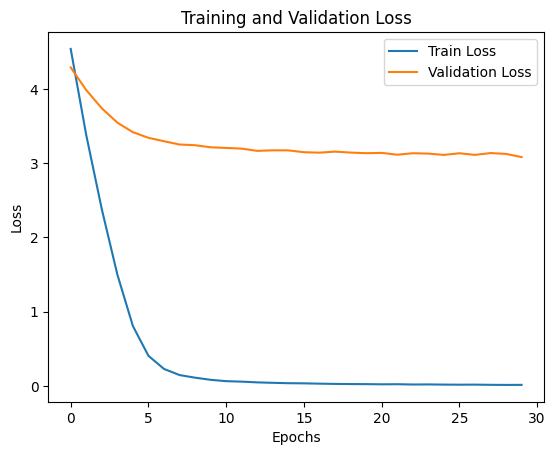

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Certainly better loss curves than previously, but it appears the model is reaching a local minimum, perhaps needs some augmentation


lets do a quick test though

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
    
    return accuracy, report

In [ ]:
test_instnces_path = './preprocessed_labels/asl100/test_instances_fixed_bboxes_short.json'
test_set = Dataset.VideoDataset(
  root=raw_path,
  instances_path=test_instnces_path,
  classes_path=classes_path,
  transform=transform
)
test_loader = DataLoader(
  test_set,
  batch_size=32,  # Adjust batch size as needed
  shuffle=False,
  num_workers=4,  # Adjust number of workers as needed
  drop_last=False
)

In [ ]:
accuracy, report = test_model(model, test_loader)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(json.dumps(report, indent=4))

Test Accuracy: 0.2442
Classification Report:
{
    "0": {
        "precision": 0.4444444444444444,
        "recall": 1.0,
        "f1-score": 0.6153846153846154,
        "support": 4.0
    },
    "1": {
        "precision": 0.375,
        "recall": 0.75,
        "f1-score": 0.5,
        "support": 4.0
    },
    "2": {
        "precision": 0.2,
        "recall": 0.2,
        "f1-score": 0.2,
        "support": 5.0
    },
    "3": {
        "precision": 0.125,
        "recall": 0.25,
        "f1-score": 0.16666666666666666,
        "support": 4.0
    },
    "4": {
        "precision": 0.5,
        "recall": 0.6666666666666666,
        "f1-score": 0.5714285714285714,
        "support": 3.0
    },
    "5": {
        "precision": 0.2,
        "recall": 0.3333333333333333,
        "f1-score": 0.25,
        "support": 3.0
    },
    "6": {
        "precision": 0.5,
        "recall": 0.6666666666666666,
        "f1-score": 0.5714285714285714,
        "support": 3.0
    },
    "7": {
        "

In [ ]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(report).iloc[:-1, :].T

In [ ]:
test_classes = test_set.classes
print(test_classes[0])

book


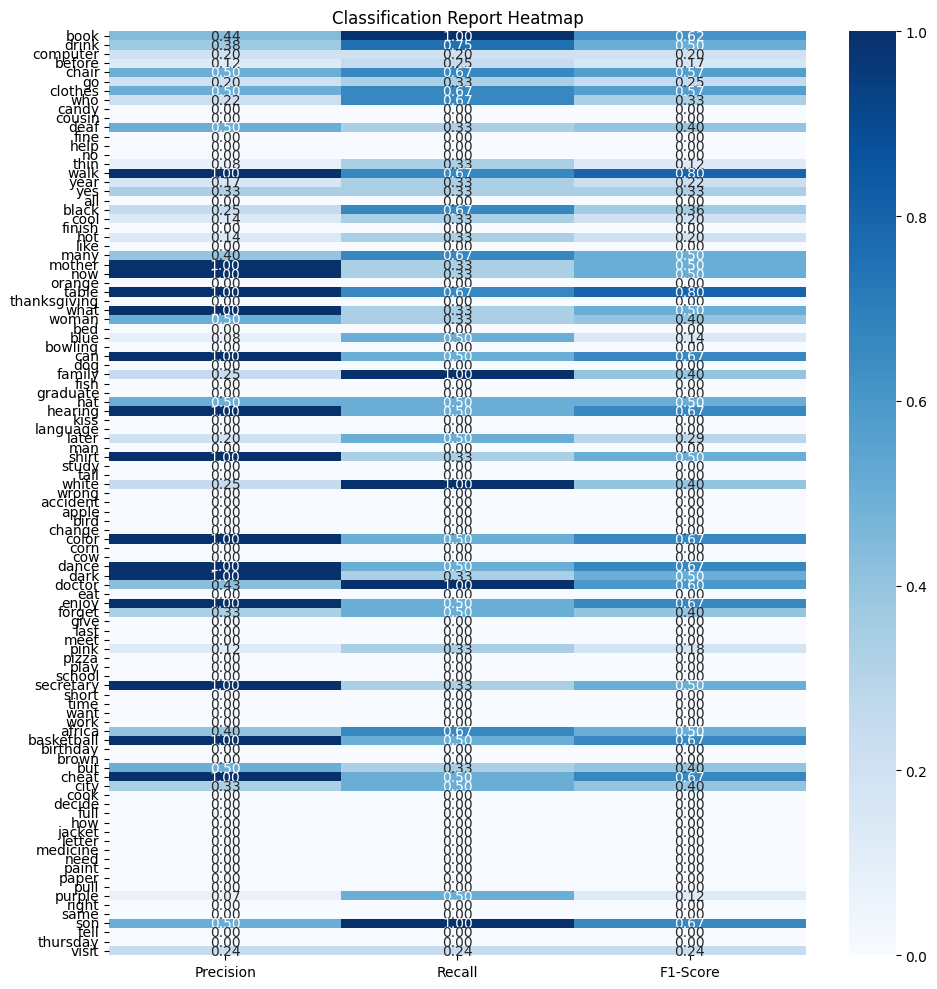

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.iloc[:-2, :3], annot=True, cmap='Blues', fmt='.2f', 
            xticklabels=['Precision', 'Recall', 'F1-Score'],
            yticklabels=[f'{test_classes[i]}' for i in range(len(df)-2)])
plt.title('Classification Report Heatmap')
plt.tight_layout()
plt.show()

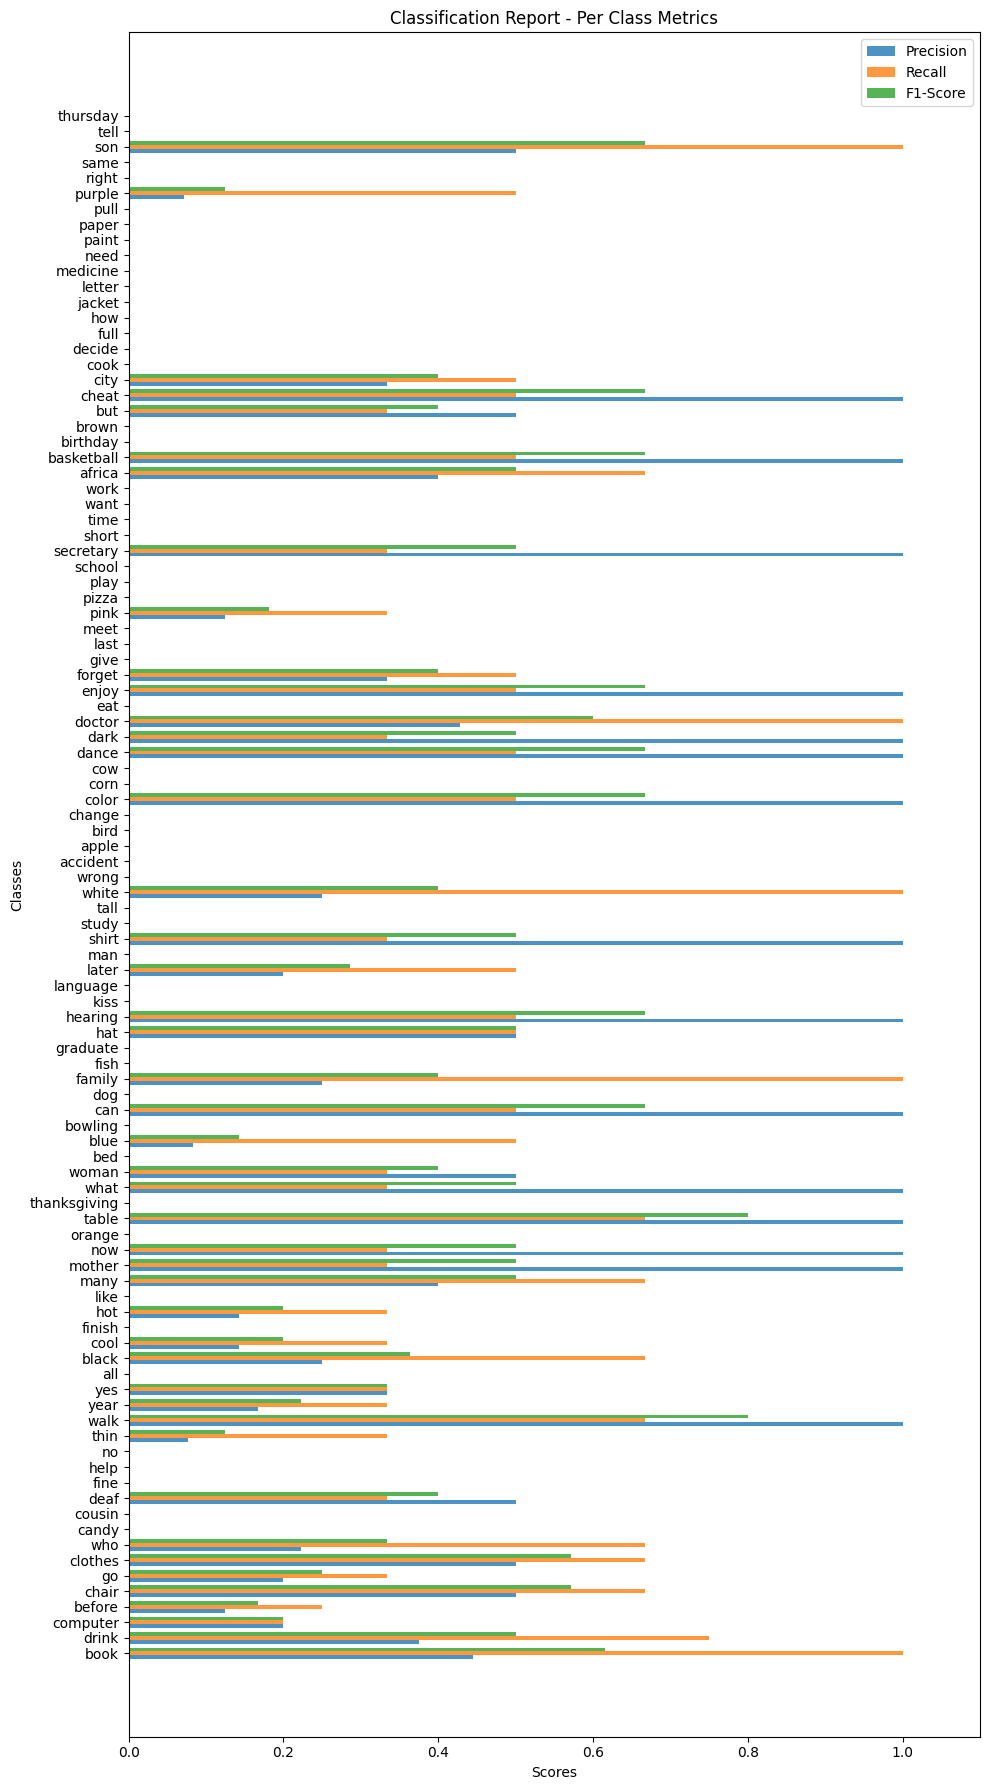

In [ ]:

# Extract metrics for plotting
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Prepare data for plotting
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

# Create bar plot
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 18))
bars1 = ax.barh(x - width, precision, height=width, label='Precision', alpha=0.8)
bars2 = ax.barh(x, recall, height=width, label='Recall', alpha=0.8)
bars3 = ax.barh(x + width, f1_score, height=width, label='F1-Score', alpha=0.8)

ax.set_ylabel('Classes')
ax.set_xlabel('Scores')
ax.set_title('Classification Report - Per Class Metrics')
ax.set_yticks(x)
ax.set_yticklabels(test_classes[:100])
ax.legend()
ax.set_xlim(0, 1.1)

plt.tight_layout()
plt.show()



In [ ]:
model_2 = video_models.r3d_18(pretrained=True)
num_classes = 100
train_inst_path = './preprocessed/labels/asl100/train_instances_fixed_bboxes_short.json'
val_inst_path = './preprocessed/labels/asl100/val_instances_fixed_bboxes_short.json'
transform2 = transforms.Compose([
  transforms.Lambda(lambda x: Dataset.correct_num_frames(x, 16)),  # (T, C, H, W)
  transforms.Lambda(lambda x: x.float() / 255.0),  # Convert
  transforms.Lambda(lambda x: F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)),  # Resize after normalization
  transforms.Lambda(lambda x: Dataset.normalise(x, mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])),  # Normalize per channel
  transforms.Lambda(lambda x: x.permute(1, 0, 2, 3)),  # (T, C, H, W) -> (C, T, H, W)
]) #This time trying the recommended transforms, also increasing resolution

train_set_2 = Dataset.VideoDataset(
  root=raw_path,
  instances_path=train_inst_path,
  classes_path=classes_path,
  transform=transform2
)
val_set_2 = Dataset.VideoDataset(
  root=raw_path,
  instances_path=val_inst_path,
  classes_path=classes_path,
  transform=transform2
)
print(f"Number of training samples: {len(train_set_2)}")
print(f"Number of validation samples: {len(val_set_2)}")


Number of training samples: 1442
Number of validation samples: 338


In [ ]:
train_loader_2 = DataLoader(
  train_set_2,
  batch_size=8, #I increased the resolution, so batch size is lower
  shuffle=True,
  num_workers=4, #reproducibility, but can be set to 4
  drop_last=True,
)
val_loader_2 = DataLoader(
  val_set_2,
  batch_size=16, #apparently can be mroe than train batch size
  num_workers=4, #to use manual seed
  shuffle=False,
  drop_last=False
)
print(f"Train loader:\n{train_loader_2}")
print(f"Validation loader:\n{val_loader_2}")

Train loader:
Validation loader:


In [ ]:
model_2.fc = nn.Linear(model_2.fc.in_features, num_classes)
model_2 = model_2.to(device)

for param in model_2.parameters():
  param.requires_grad = True
  
for layer_name in ['layer4', 'fc']:
  if hasattr(model_2, layer_name):
    for param in getattr(model_2, layer_name).parameters():
      param.requires_grad = True
      
for name, param in model_2.named_parameters():
  if param.requires_grad:
    print(f"Training parameter: {name}")
  else:
    print(f"Freezing parameter: {name}")
    
for name, module in model_2.named_modules():
  if isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
    # Check if this BatchNorm is in a frozen layer
    is_in_frozen_layer = not any(unfreeze_layer in name for unfreeze_layer in ['layer4', 'fc'])
    
    if is_in_frozen_layer:
      module.eval()
      module.track_running_stats = False
      print(f"Set {name} to eval mode (frozen layer)")

Training parameter: stem.0.weight
Training parameter: stem.1.weight
Training parameter: stem.1.bias
Training parameter: layer1.0.conv1.0.weight
Training parameter: layer1.0.conv1.1.weight
Training parameter: layer1.0.conv1.1.bias
Training parameter: layer1.0.conv2.0.weight
Training parameter: layer1.0.conv2.1.weight
Training parameter: layer1.0.conv2.1.bias
Training parameter: layer1.1.conv1.0.weight
Training parameter: layer1.1.conv1.1.weight
Training parameter: layer1.1.conv1.1.bias
Training parameter: layer1.1.conv2.0.weight
Training parameter: layer1.1.conv2.1.weight
Training parameter: layer1.1.conv2.1.bias
Training parameter: layer2.0.conv1.0.weight
Training parameter: layer2.0.conv1.1.weight
Training parameter: layer2.0.conv1.1.bias
Training parameter: layer2.0.conv2.0.weight
Training parameter: layer2.0.conv2.1.weight
Training parameter: layer2.0.conv2.1.bias
Training parameter: layer2.0.downsample.0.weight
Training parameter: layer2.0.downsample.1.weight
Training parameter: la

In [ ]:
trainable_params_2 = [p for p in model_2.parameters() if p.requires_grad]
optimizer_2 = torch.optim.Adam(trainable_params_2, lr=1e-4)  # Adjust learning rate as needed

train_losses_2, val_losses_2 = train_model_3(
  model=model_2,
  train_loader=train_loader_2,
  optimizer=optimizer_2,
  loss_func=loss_func,
  epochs=30,
  val_loader=val_loader_2,
  output='runs/r3d18_exp3'
)

### cuda out of memory with batch size of 16